In [3]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

import matplotlib.pylab as plt
plt.style.use('ggplot')
%matplotlib inline

In [4]:
# Reading the datasets
df_train = pd.read_csv("data/stores_train.csv")
df_test = pd.read_csv("data/stores_test.csv")
df_bus_stops = pd.read_csv("data/busstops_norway_fixed.csv")
df_grunnkrets_age_dist = pd.read_csv("data/grunnkrets_age_distribution.csv")
df_grunnkrets_house_pers = pd.read_csv("data/grunnkrets_households_num_persons.csv")
df_grunnkrets_income_house = pd.read_csv("data/grunnkrets_income_households.csv")
df_grunnkrets_stripped = pd.read_csv("data/grunnkrets_norway_stripped.csv")
df_plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
df_extra = pd.read_csv("data/stores_extra.csv")

In [5]:
# Only select 2016 year
df_grunnkrets_stripped = df_grunnkrets_stripped[df_grunnkrets_stripped.year == 2016]
df_grunnkrets_age_dist = df_grunnkrets_age_dist[df_grunnkrets_age_dist.year == 2016]
df_grunnkrets_house_pers = df_grunnkrets_house_pers[df_grunnkrets_house_pers.year == 2016]
df_grunnkrets_income_house = df_grunnkrets_income_house[df_grunnkrets_income_house.year == 2016]

In [6]:
df_grunnkrets_bus_count = df_grunnkrets_stripped.loc[:, ['grunnkrets_id', 'area_km2']]
amount_bus_stop = df_grunnkrets_bus_count['grunnkrets_id'].map(df_bus_stops['grunnkrets_id'].value_counts())
df_grunnkrets_bus_count['amount_bus_stop'] = amount_bus_stop
df_grunnkrets_bus_count['amount_bus_stop'] = df_grunnkrets_bus_count['amount_bus_stop'].replace(np.nan, 0)
df_grunnkrets_bus_count

,grunnkrets_id,area_km2,amount_bus_stop
260,10010507,0.158484,4.0
261,10011105,0.474242,0.0
262,10011604,1.464307,18.0
263,10011703,0.484497,0.0
264,10011707,0.388282,1.0
...,...,...,...
26531,9010116,0.040685,0.0
26532,9040107,0.377123,0.0
26533,9064304,3.013260,9.0
26534,9065309,0.204316,0.0


In [7]:
df_grunnkrets_population = df_grunnkrets_age_dist.loc[:, ['grunnkrets_id']]
df_grunnkrets_population['total_population'] = df_grunnkrets_age_dist.iloc[:,2:92].sum(axis=1)
df_grunnkrets_population['youngs'] = df_grunnkrets_age_dist.iloc[:,2:20].sum(axis=1)
df_grunnkrets_population['adults'] = df_grunnkrets_age_dist.iloc[:,21:64].sum(axis=1)
df_grunnkrets_population['seniors'] = df_grunnkrets_age_dist.iloc[:,65:92].sum(axis=1)
df_grunnkrets_population.head()

,grunnkrets_id,total_population,youngs,adults,seniors
1,16013117,944,96,842,0
3,16011203,880,26,753,89
4,3011601,645,61,553,24
8,3010807,528,29,454,39
11,3012307,876,49,796,24


In [8]:
df_grunnkrets_income = df_grunnkrets_income_house.iloc[:,0:3]
df_grunnkrets_income = df_grunnkrets_income.drop(['year'], axis=1)
df_grunnkrets_income

,grunnkrets_id,all_households
0,14200105,551700
3,14200401,507000
11,14200402,507000
12,14200101,551700
13,14200103,551700
...,...,...
26525,18250101,469500
26526,18250107,469500
26527,18250103,469500
26528,18250106,469500


In [ ]:
#check if shop is close to one of the big cities

OSLO = np.array((59.91, 10.75))
BERGEN = np.array((60.39, 5.32))
TRONDHEIM = np.array((63.44, 10.42))
STAVANGER = np.array((58.96, 5.73))
cities = [OSLO, BERGEN, TRONDHEIM, STAVANGER]

def close_to_city(row):
    for i in cities:
        if np.linalg.norm(i - np.array((row.loc["lat"], row.loc["lon"]))) <= 0.2:
            return True
    return False

In [9]:
df_sales_channel_train = df_train[['store_id','sales_channel_name']]
labelencoder = LabelEncoder()
df_sales_channel_train_encoded = labelencoder.fit_transform(df_sales_channel_train['sales_channel_name'])
df_sales_channel_train= pd.DataFrame(df_train['store_id'])
df_sales_channel_train.insert(1, 'sales_channel_name',df_sales_channel_train_encoded, True)

#encoder df_test sales_channel
df_sales_channel_test = df_test[['store_id','sales_channel_name']]
labelencoder = LabelEncoder()
df_sales_channel_test_encoded = labelencoder.fit_transform(df_sales_channel_test['sales_channel_name'])
df_sales_channel_test= pd.DataFrame(df_test['store_id'])
df_sales_channel_test.insert(1, 'sales_channel_name',df_sales_channel_test_encoded, True)
df_sales_channel_test.head()

,store_id,sales_channel_name
0,914206820-914239427-717245,35
1,916789157-916823770-824309,35
2,913341082-977479363-2948,35
3,889682582-889697172-28720,35
4,997991699-998006945-417222,35


In [10]:
#train
# Selecting features from initial dataframe
X_train = df_train.loc[:, ['grunnkrets_id', 'lat', 'lon']]
# Adding feature chain/mall name encoded
X_train['encoded_mall'] = np.where(df_train['mall_name'].isna(), 0, 1)
X_train['encoded_chain'] = np.where(df_train['chain_name'].isna(), 0, 1)
# Adding feature number of bus stop
X_train = pd.merge(X_train, df_grunnkrets_bus_count, on="grunnkrets_id", how="left")
# Adding feature number of people per grunnkret
X_train = pd.merge(X_train, df_grunnkrets_population, on="grunnkrets_id", how="left")
# Adding feature income per grunnkret
X_train = pd.merge(X_train, df_grunnkrets_income, on="grunnkrets_id", how="left")
# Adding feature sale channel encoded
X_train['sales_channel_name'] = df_sales_channel_train['sales_channel_name']
#Adding feature near city 
X_train["near_city"] = df_train.apply(close_to_city, axis=1)
X_train["near_city"] = np.where(X_train.near_city == True, 1, 0)

#test
X_test = df_test.loc[:, ['grunnkrets_id', 'lat', 'lon']]
X_test['encoded_mall'] = np.where(df_test['mall_name'].isna(), 0, 1)
X_test['encoded_chain'] = np.where(df_test['chain_name'].isna(), 0, 1)
X_test = pd.merge(X_test, df_grunnkrets_bus_count, on="grunnkrets_id", how="left")
X_test = pd.merge(X_test, df_grunnkrets_population, on="grunnkrets_id", how="left")
X_test = pd.merge(X_test, df_grunnkrets_income, on="grunnkrets_id", how="left")
X_test['sales_channel_name'] = df_sales_channel_test['sales_channel_name']
#Adding feature near city 
X_test["near_city"] = df_test.apply(close_to_city, axis=1)
X_test["near_city"] = np.where(X_test.near_city == True, 1, 0)

# Removing the ID of the grunnkret, now it's not useful
X_train = X_train.drop(['grunnkrets_id'], axis=1)
X_test = X_test.drop(['grunnkrets_id'], axis=1)

# X_train = X_train.drop(['amount_bus_stop'], axis=1)
# X_test = X_test.drop(['amount_bus_stop'], axis=1)

X_train = X_train.drop(['lat', "lon"], axis=1)
X_test = X_test.drop(['lat', "lon"], axis=1)


# Filling Nan (should be improve cause I don't know what I'm doing here 0_o )
X_train = X_train.apply(lambda x: x.fillna(x.mean()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)

X_train['special_feature'] = X_train['amount_bus_stop']*X_train['total_population'] + X_train['total_population']*X_train['area_km2'] + X_train['area_km2']*X_train['amount_bus_stop']
X_test['special_feature'] = X_test['amount_bus_stop']*X_test['total_population'] + X_test['total_population']*X_test['area_km2'] + X_test['area_km2']*X_test['amount_bus_stop']

scaler = MinMaxScaler(feature_range = (0, 1))
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.fit_transform(X_test)

Y_train = df_train.loc[:, ['revenue', ]]
Y_train = scaler.fit_transform(Y_train)

X_test

,lat,lon,encoded_mall,encoded_chain,area_km2,amount_bus_stop,total_population,youngs,adults,seniors,all_households,sales_channel_name,special_feature
0,0.133446,0.210585,1.0,1.0,0.010377,0.000000,0.016197,0.013090,0.030117,0.021186,0.462583,0.422222,0.000192
1,0.146470,0.230556,0.0,1.0,0.017610,0.277778,0.118496,0.076884,0.125739,0.167619,0.434853,0.422222,0.061606
2,0.165624,0.212462,1.0,1.0,0.010668,0.055556,0.052303,0.036426,0.062744,0.076271,0.403643,0.422222,0.006301
3,0.708893,0.368169,1.0,1.0,0.006326,0.138889,0.069512,0.024474,0.093698,0.085805,0.457130,0.422222,0.018946
4,0.409317,0.216998,1.0,1.0,0.016730,0.111111,0.118496,0.076884,0.125739,0.167619,0.723634,0.422222,0.025514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,0.108505,0.221004,0.0,0.0,0.019414,0.361111,0.244306,0.104155,0.208310,0.576271,0.443091,0.055556,0.157681
12855,0.214101,0.229032,1.0,1.0,0.009137,0.000000,0.074237,0.021628,0.096207,0.112288,0.338786,0.055556,0.000540
12856,0.148973,0.240885,1.0,1.0,0.008220,0.055556,0.177493,0.077974,0.188790,0.294492,0.510732,0.055556,0.018578
12857,0.065310,0.041890,1.0,0.0,0.002315,0.000000,0.036950,0.012521,0.049359,0.080508,0.443671,0.055556,0.000076


In [12]:
model1 = RandomForestRegressor(n_estimators=200, random_state=0)
model1.fit(X_train, np.ravel(Y_train))
features = X_train.columns
importances = model1.feature_importances_
indices = np.argsort(importances)[-13:]
#rfr_prediction = model.predict(X_train_test)
#rfr_mse = rmsle(rfr_prediction, np.ravel(Y_train_test))
Y_Pred = model1.predict(X_test)

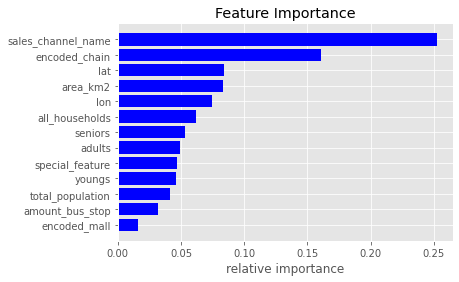

In [13]:
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("relative importance")
plt.title("Feature Importance")
plt.show()

#maybe improve sales_channel_name and chain encoding -> frequency/count encoding?

In [ ]:
import autosklearn.regression

#autoML -> generates ensemble for you and chooses hyperparameters on itself

model = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=600, per_run_time_limit=70)
model.fit(X_train, np.ravel(Y_train))
print(model.leaderboard())

In [ ]:
#train_predictions = model.predict(X_train)
#print("Train R2 score:", sklearn.metrics.r2_score(Y_train, train_predictions))

Y_Pred = model.predict(X_test)

In [ ]:
# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = df_test.store_id 
submission['predicted'] = np.asarray(scaler.inverse_transform([[elmt] for elmt in Y_Pred]))

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission